## Exploratory data analysis for Symbiosis4Growth

In [18]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import NamedStyle

### Plotting and analysis

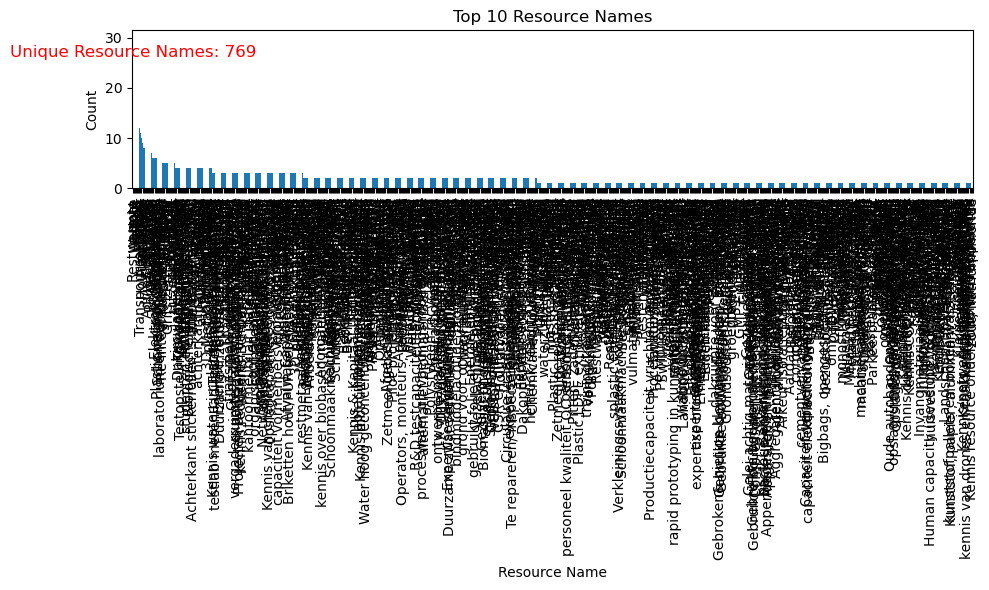

In [19]:
# Read the Excel file
data = pd.read_excel('RESOURCES.xlsx')

# Get the count of each resource name
resource_counts = data['Resource Name'].value_counts()

# Get the number of unique values in the 'Resource Name' column
unique_resource_count = data['Resource Name'].nunique()

# Define the number of top resources to plot
top_n = 10

# Select the top N resource counts
top_resource_counts = resource_counts.head(top_n)

# Plot the counts of each resource name
plt.figure(figsize=(10, 6))
resource_counts.plot(kind='bar')
plt.title(f'Top {top_n} Resource Names')
plt.xlabel('Resource Name')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Display the number of unique resource names as text on the plot
plt.text(0.5, max(top_resource_counts.head(top_n)) * 0.9, f'Unique Resource Names: {unique_resource_count}', 
         horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')

plt.tight_layout()
plt.show()

In [20]:
# Get the number of unique values in the 'Resource Name' column
unique_resource_count = data['Resource Name'].nunique()
print(unique_resource_count)

769


In [21]:
# More info about the data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Resource Name             1560 non-null   object        
 1   Description               1514 non-null   object        
 2   Site Name                 1560 non-null   object        
 3   SIC Code                  1560 non-null   object        
 4   SIC Description           1560 non-null   object        
 5   Street and Number         1560 non-null   object        
 6   Address 2                 77 non-null     object        
 7   Address 3                 0 non-null      float64       
 8   Address 4                 0 non-null      float64       
 9   Postal Code               1560 non-null   object        
 10  City                      1560 non-null   object        
 11  Region                    1560 non-null   object        
 12  Supply Type         

In [22]:
# Check for missing values, classification 1, 2 and 3 seem to have zero.
print(data['Classification 1'].isnull().sum())

0


In [23]:
# Example of classification value that is not null, but contains nothing
classification_1_value = data.iloc[13]['Classification 1']
print(classification_1_value)

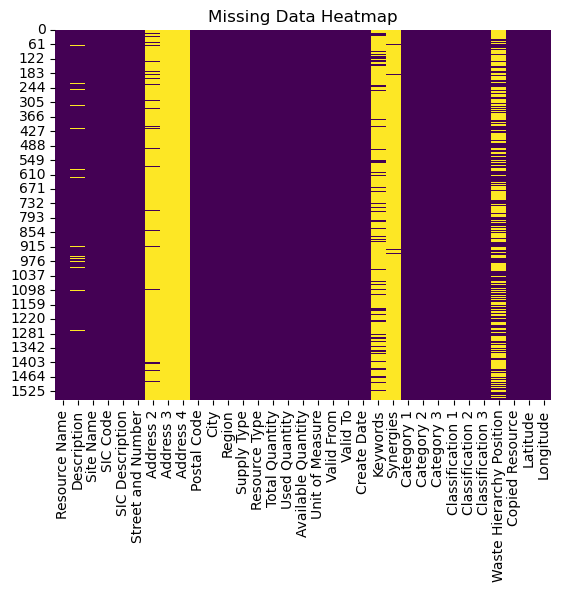

In [24]:
## Visualize missing data
# Yellow is missing data, Classification 1, 2 and 3 still have whitespaces.
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

### Editing data and testing Recommendation Algorithm

In [25]:
# Read the Excel file
data = pd.read_excel('RESOURCES.xlsx')

#### Removing whitespace entries from Classification columns

In [26]:
# Function to update classification columns
def update_classification_columns(df, columns):
    for col in columns:
        # Check if the column contains only whitespace
        empty_but_not_nan = df[col].apply(lambda x: isinstance(x, str) and x.strip() == '')
        
        # Update the entries containing just whitespace
        if col == "Classification 1":
            df.loc[empty_but_not_nan, col] = '99 Unassignable'
        elif col == "Classification 2":
            df.loc[empty_but_not_nan, col] = '99 99 Unassignable'
        elif col == "Classification 3":
            df.loc[empty_but_not_nan, col] = '99 99 99 Unassignable'
    return df

# Update classification columns
classification_columns = ["Classification 1", "Classification 2", "Classification 3"]
data = update_classification_columns(data, classification_columns)

print(data['Classification 3'])


0                        99 99 99  Unassignable
1                        99 99 99  Unassignable
2                       20 02 02  soil & stones
3                        99 99 99  Unassignable
4                        99 99 99  Unassignable
                         ...                   
1555                     99 99 99  Unassignable
1556                     99 99 99  Unassignable
1557                     99 99 99  Unassignable
1558                     99 99 99  Unassignable
1559    06 03 14  solid salts & solutions n.e.s
Name: Classification 3, Length: 1560, dtype: object


#### Removing category and classification codes and adding them to a column

In [27]:
# Function to split codes and text for specified columns
def split_codes_and_text(df, columns):
    for col in columns:
        # Create a new column for the codes
        df[f"{col} Code"] = df[col].str.extract(r'^(\d+(?:\s\d+)*)')[0]
        
        # Remove codes from the original category columns
        df[col] = df[col].str.replace(r'^\d+(?:\s\d+)*\s','', regex=True).str.strip()
    return df

# Columns to process
category_columns = ["Category 1", "Category 2", "Category 3"]
classification_columns = ["Classification 1", "Classification 2", "Classification 3"]

# Process category columns
data = split_codes_and_text(data, category_columns)

# Process classification columns
data = split_codes_and_text(data, classification_columns)

print(data[['Classification 3', 'Classification 3 Code']])


                   Classification 3 Classification 3 Code
0                      Unassignable              99 99 99
1                      Unassignable              99 99 99
2                     soil & stones              20 02 02
3                      Unassignable              99 99 99
4                      Unassignable              99 99 99
...                             ...                   ...
1555                   Unassignable              99 99 99
1556                   Unassignable              99 99 99
1557                   Unassignable              99 99 99
1558                   Unassignable              99 99 99
1559  solid salts & solutions n.e.s              06 03 14

[1560 rows x 2 columns]


In [28]:
data.head()
data['Classification 3']

0                        Unassignable
1                        Unassignable
2                       soil & stones
3                        Unassignable
4                        Unassignable
                    ...              
1555                     Unassignable
1556                     Unassignable
1557                     Unassignable
1558                     Unassignable
1559    solid salts & solutions n.e.s
Name: Classification 3, Length: 1560, dtype: object

In [34]:
import pandas as pd

# Extract unique values for Category (across all levels)
categories = pd.concat([data['Category 1'], data['Category 2'], data['Category 3']]).dropna().unique()

# Clean the categories: remove unwanted spaces, "Unspecified", empty strings, and duplicates
categories = [cat.strip() for cat in categories if cat not in ['Unspecified', '', '0']]

# Extract unique values for Unit of Measurement
unit_of_measurement = data['Unit of Measure'].dropna().unique()

# Replace "Money (€)" with "MoneyEUR"
unit_of_measurement = [unit.replace("Money (€)", "MoneyEUR") for unit in unit_of_measurement]

# Output cleaned categories and units of measurement
print("Cleaned Categories:")
print(categories)

print("\nUnique Units of Measurement:")
print(unit_of_measurement)

# Save cleaned categories and unit of measurement to CSV
pd.Series(categories).to_csv("cleaned_unique_categories.csv", index=False)
pd.Series(unit_of_measurement).to_csv("unique_unit_of_measurement.csv", index=False)

Cleaned Categories:
['Capacity', 'Food & Agriculture', 'Energy', 'Plastic', 'WEEE', 'Organic Chemicals', 'Coatings/Adhesiv/Sealants/Colourants/Print Inks', 'Packaging', 'Wood', 'Water', 'Inorganics', 'Metals', 'Rubber', 'Textiles, Leather, Fur', 'Minerals and Ceramics', 'Expertise', 'Land', 'Logistics', 'Glass', 'Surplus Machinery, Appliances and Equipment', 'Compost, Peat Etc', 'Equipment', 'Manufacturing / Processing', 'Green Waste', 'Arable Produce & Wastes (Non-Fuel)', 'Heat', 'Other', 'Batteries', 'Solvents', 'Paints & Varnishes', 'Plastic (Unspecified)', 'Labour', 'Other Food & Beverage Wastes', 'Prepared Food Waste', 'Soaps, Detergents, Oils, Waxes, Etc', 'Polyurethane PU PUR', 'Product', 'Processed Wood', 'Wastewater', 'Waste Handling Facilities', 'Production', 'Alcohols, Glycols, Glycerol', 'Calcium Compounds (See Also Alkalis)', 'Alkalies', 'Organic Acids, Salts & Anhydrides', 'Pure Metals', 'Aluminum Compounds', 'Tyres', 'Alloys, Including Steel', 'Nitrogen Compounds, Ammoni

#### Dropping Address columns

In [30]:
data = data.drop(columns=['Address 2', 'Address 3', 'Address 4'])
data.head()

,Resource Name,Description,Site Name,SIC Code,SIC Description,Street and Number,Postal Code,City,Region,Supply Type,...,Waste Hierarchy Position,Copied Resource,Latitude,Longitude,Category 1 Code,Category 2 Code,Category 3 Code,Classification 1 Code,Classification 2 Code,Classification 3 Code
0,1x vrije vrachtwagen met chauffeur,"Een vrije vrachtwagen, incl. chauffeur, voor t...",NOVO Packaging - Stampersgat - Production,46.49,Groothandel in overige consumentenartikelen (n...,Dennis Leestraat 107A,4754 BC,Stampersgat,West-Brabant,Continuous,...,Reused,No,51.612869,4.45410,01,01 06,01 06 02,99,99 99,99 99 99
1,1x vrije vrachtwagen met chauffeur,"Een vrije vrachtwagen, incl. chauffeur, voor t...",Pondres - Tilburg - Head office,18.12,Overige drukkerijen,Kraaivenstraat 19,5048 AB,Tilburg,Noord-Brabant,Continuous,...,NaN,Yes,0.000000,0.00000,01,01 06,01 06 02,99,99 99,99 99 99
2,3 ha zandgrond,3 ha zandgrond landbouw kwaliteit in Strijbeek,Werkplaats de Gruyter - ’s-Hertogenbosch - Hea...,70.22,Advisering op het gebied van management en bed...,Veemarktkade 8,5222 AE,’s-Hertogenbosch,West-Brabant,Continuous,...,NaN,No,51.701561,5.28765,06,06 03,06 03 04,20,20 02,20 02 02
3,3D Metaalprintcapaciteit,"3D Metaalprintcapaciteit, volume 250x250X300mm...",Renishaw Benelux BV - Breda - Head office,26.60,Vervaardiging van bestralingsapparatuur en van...,Nikkelstraat 3,4823 AE,Breda,West-Brabant,Continuous,...,NaN,No,51.611622,4.71945,01,01 10,01 10 02,99,99 99,99 99 99
4,3D Metaalprintcapaciteit,"3D Metaalprintcapaciteit, volume 250x250X300mm...",Tata Steel NL Tubes BV,24.10,Vervaardiging van ijzer en staal en van ferrol...,Souvereinstraat 35,4903 RH,Oosterhout,West-Brabant,Continuous,...,NaN,Yes,51.623550,4.88702,01,01 10,01 10 02,99,99 99,99 99 99


#### Saving dataset

In [31]:
data.to_excel('RESOURCES_CLEANED.xlsx', index=False)